# 02. Logistic Regression in scikit-learn and PyTorch

In this notebook, we are going to implement a simple multi-class logistic regression in both scikit-learn and PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data: Iris Dataset (scikit-learn)

We are going to use the Iris data set from scikit-learn - a 150 instance, 3-class data set with 4 features.

For now, we won't bother with the standard train/test splits and simply build a working model.

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])


In [3]:
print(iris.data.shape)
print(iris.target.shape)

(150, 4)
(150,)


In [4]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [5]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Note that our target $y$ is encoded as a single array with classes as its values.

## 2. Logistic Regression in scikit-learn

We will use the built-in `LogisticRegression` classifier in scikit-learn. To make this implementation consistent with our PyTorch formulation, we will slightly modify the defaults - namely modifying the multi-class calculation to use a softmax, and turning off the regularization.

(If you do not know what 'regularization' means, it will be covered in a later lecture. For now, just know it is an additional part of the model we are not concerned with.)

First, we set up the model with our desired arguments.

In [6]:
from sklearn.linear_model import LogisticRegression
sk_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000000,
    C=np.finfo(np.float).max,
)

Next, we fit the model to the data

In [7]:
sk_model.fit(X=iris.data, y=iris.target)

LogisticRegression(C=1.7976931348623157e+308, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000000,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

Finally, we can predict probabilities that each sample is in each class. Note that the probabilities here will be *very* high, because we are clearly overfitting to the data set.

In [8]:
sk_model.predict_proba(X=iris.data)[:5]

array([[1.00000000e+00, 9.71822246e-35, 1.49417055e-61],
       [1.00000000e+00, 1.13758507e-27, 8.08705362e-53],
       [1.00000000e+00, 5.53256279e-31, 6.59096956e-57],
       [1.00000000e+00, 1.08570929e-25, 2.12830090e-50],
       [1.00000000e+00, 1.70014979e-35, 1.71464960e-62]])

## 3. Logistic Regression in PyTorch

First, we will import some modules from PyTorch.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Next, we will implement a model in PyTorch -- as an `nn.Module`.

A `nn.Module` can really be any function, but it is often used to implement layers, functions and models. Note that you can also nest modules.

Importantly, modules need to have their `forward()` method overridden, and very often you will want to override the `__init__` method as well. 

The `__init__` method sets up the module, akin to how we set up the `LogisticRegression` model above with some arguments. This is also often where the internal modules and parameters are initialized.

The `forward` method defines what happens when you *apply* the module.

In the background, PyTorch makes use of your code in the forward method and determines how to implement back-propagation with it - but all you need to do is to define the forward pass!

As a reminder, softmax 

In [10]:
class LogisticRegressionPyTorch(nn.Module):
    def __init__(self, n_in, n_out):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        super().__init__()
        self.linear = nn.Linear(n_in, n_out)
        self.init_weights()
        
    def forward(self, x):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        # Apply the linear function to get our logit (real numbers)
        logit = self.linear(x)
        # Apply log_softmax to get logs of normalized probabilities
        return F.log_softmax(logit, dim=1)
    
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

In [11]:
x = torch.from_numpy(iris.data).float()
y = torch.from_numpy(iris.target)

In [12]:
# List to record our loss over time
loss_val_ls = []

# Initialize our model. Note we need to provide n_in and n_out
pt_model = LogisticRegressionPyTorch(n_in=x.shape[1], n_out=3)

# Set up the criterion - loss function
criterion = nn.NLLLoss()

# Set up the optimizer. We need to tell the optimizer which
#   parameters it will optimize over (which parameters it is
#   allowed to modify).
optimizer = optim.Adam(pt_model.parameters(), lr=0.1)

In [13]:
# As a quick check, lets investigate the number of parameters in our model:
for param in pt_model.parameters():
    print(param.shape)

torch.Size([3, 4])
torch.Size([3])


In [14]:
# Run over many iterations!
for i in range(10000):
    
    # Always zero-out the gradients managed by your optimizer
    # PyTorch does not automatically zero-out your gradients
    #   You can also do pt_model.zero_grad() in this case.
    optimizer.zero_grad()
    
    # !! Put model into training mode. This does not do anything
    #   in a simple Logistic Regression model, but will be important 
    #   later. (See: Dropout)
    pt_model.train()
    
    # Compute the predicted log-probabilities
    y_hat = pt_model(x)
    
    # Compute the loss
    train_loss = criterion(y_hat, y)
    
    # Back-propagate the gradients to the parameters
    train_loss.backward()
    
    # Apply the gradient updates to the parameters
    optimizer.step()
    
    # Recompute the loss in evaluation mode, and record it.
    # Again, this does not do anything here, but will be important later.
    # Since we are evaluating, we will also tell PyTorch not to
    #   compute gradients.
    pt_model.eval()
    with torch.no_grad():
        y_hat = pt_model(x)
        eval_loss = criterion(y_hat, y)
        
    # Record the loss
    # Note that 'loss' is a Tensor, but loss.item() is a number
    loss_val_ls.append(eval_loss.item())

Text(0,0.5,'Log Loss')

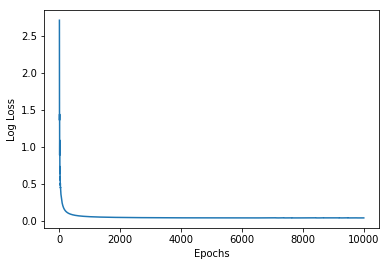

In [15]:
plt.plot(loss_val_ls)
plt.xlabel("Epochs")
plt.ylabel("Log Loss")

In [16]:
# See our final loss
loss_val_ls[-1]

0.039776649326086044

To confirm that our model is doing the right thing, we do a quick test - create a new logistic regression model in PyTorch, but insert the weights learned from our scikit-learn model, then compute the loss similarly.

Note that it is numerically similar to the loss above.

In [17]:
with torch.no_grad():
    blank_model = LogisticRegressionPyTorch(n_in=x.shape[1], n_out=3)
    blank_model.linear.weight.set_(
        torch.from_numpy(sk_model.coef_).float()
    )
    blank_model.linear.bias.set_(
        torch.from_numpy(sk_model.intercept_).float()
    )
    y_hat = blank_model(x)
    print(criterion(y_hat, y).item())

0.039661891758441925


## 4. Further Exploration

1. We asserted that the models are roughly equivalent because they reached the same losses. But is this true? Can we directly compare the parameter values? (Try it!) What if the parameter values are different?

2. In scikit-learn, you can use `.predict_proba` to compute the predicted probabilities. How do we do the same for our PyTorch model?

3. Although we showed that the loss is numerically the same, and you can confirm for yourself that the predictions $\hat{y}$ are numerically similar between the scikit-learn and PyTorch implementations, if you inspect the actual weights and biases, you will notice that they are different. Why is this the case?

For Question 1:

No, the parameters are not similar. Similar loss level doen't gives similar models.

For Question 2:

In [18]:
torch.exp(pt_model(x))

tensor([[1.0000e+00, 1.0823e-08, 1.9161e-35],
        [1.0000e+00, 6.7665e-07, 5.4951e-32],
        [1.0000e+00, 1.3463e-07, 1.8380e-33],
        [1.0000e+00, 1.8953e-06, 4.2526e-31],
        [1.0000e+00, 7.2635e-09, 8.4490e-36],
        [1.0000e+00, 1.4114e-08, 5.4430e-34],
        [1.0000e+00, 2.1954e-07, 1.6169e-32],
        [1.0000e+00, 6.7309e-08, 7.6260e-34],
        [9.9999e-01, 6.3196e-06, 3.4291e-30],
        [1.0000e+00, 3.4855e-07, 5.9948e-33],
        [1.0000e+00, 2.3904e-09, 1.3676e-36],
        [1.0000e+00, 2.8092e-07, 1.3384e-32],
        [1.0000e+00, 4.2304e-07, 7.0605e-33],
        [1.0000e+00, 1.6836e-07, 5.6920e-34],
        [1.0000e+00, 7.3192e-12, 1.2484e-41],
        [1.0000e+00, 3.2447e-11, 3.2323e-39],
        [1.0000e+00, 5.3755e-10, 4.7664e-37],
        [1.0000e+00, 2.3507e-08, 2.5911e-34],
        [1.0000e+00, 5.2518e-09, 3.0235e-35],
        [1.0000e+00, 6.4242e-09, 2.4620e-35],
        [1.0000e+00, 1.0145e-07, 2.8274e-33],
        [1.0000e+00, 2.8230e-08, 1

For Question 3:

Because the multi-class regression is over-parameterized / not identifiable, which means there are more than one unique solution. Therefore, different models (like above sk_model and pt_model) can have similar loss with different weights and biases. 